# Deploying trained Le Net model

In [1]:
%matplotlib inline
import numpy as np

caffe_root = '../../../caffe/'

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

/home/mily/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import os
np_loaded_data_file = '../data/train_data_cleaned.npz'
if not os.path.isfile(np_loaded_data_file):
    print "%s does not exist. See facial_recog_kaggle.ipynb" % np_loaded_data_file
else:
    print "loading %s" % np_loaded_data_file
    npzfile = np.load(np_loaded_data_file)
    print "loaded: ", npzfile.files
    X_train_clean_cv, y_train_clean_cv = npzfile['X_train_clean_cv'], npzfile['y_train_clean_cv']
    X_val_clean_cv, y_val_clean_cv = npzfile['X_val_clean_cv'], npzfile['y_val_clean_cv']
    feature_labels = npzfile['feature_labels']
    print X_train_clean_cv.shape, y_train_clean_cv.shape
    print X_val_clean_cv.shape, y_val_clean_cv.shape


loading ../data/train_data_cleaned.npz
loaded:  ['X_val_clean_cv', 'y_val_clean_cv', 'y_train_clean_cv', 'feature_labels', 'X_train_clean_cv']
(1628, 1, 96, 96) (1628, 30)
(512, 1, 96, 96) (512, 30)


In [3]:
net = caffe.Net('test_net.prototxt',
                'good_models/lenet__b_lr_5.41e-03__reg_param_4.64e-03__batch_size_64.caffemodel',
                caffe.TEST)

## Sanity Checks

In [4]:
[(k, v[0].data.shape, v[1].data.shape) for k, v in net.params.items()]

[('conv1', (20, 1, 5, 5), (20,)),
 ('conv2', (50, 20, 5, 5), (50,)),
 ('fc1', (500, 22050), (500,)),
 ('score', (30, 500), (30,))]

In [5]:
def euclidean_loss(a, b):
    batch_size, num_labels = a.shape
    
    return np.sum((a-b)**2) / float(batch_size * 2)
    
# Make sure train error and validation error are as expected. 
train_size = X_train_clean_cv.shape[0]
val_size = X_val_clean_cv.shape[0]
num_labels = y_train_clean_cv.shape[1]

train_error = 0
num_batches = 10
batch_size = 64
out_train_clean_cv = np.zeros_like(y_train_clean_cv)
for it in range(num_batches):
    it_range = range(it*batch_size,it*batch_size+batch_size)
    net.blobs['data'].data[...] = X_train_clean_cv[it_range]
    net.forward()
    out = net.blobs['score'].data
    out_train_clean_cv[it_range, :] = out
    
    train_error += euclidean_loss(out, y_train_clean_cv[it_range])
train_error = train_error / float(num_batches * batch_size)  

print train_error



1.18769111011


In [6]:
num_batches = 3
batch_size = 64
val_error = 0
out_val_clean_cv = np.zeros_like(y_val_clean_cv)

for it in range(num_batches):
    it_range = range(it*batch_size,it*batch_size+batch_size)
    net.blobs['data'].data[...] = X_val_clean_cv[it_range]
    net.forward()
    out = net.blobs['score'].data
    out_val_clean_cv[it_range, :] = out
    
    val_error += euclidean_loss(out, y_val_clean_cv[it_range])
val_error = val_error / float(num_batches * batch_size)  
print val_error

1.16612941712


[[1303 1620  381 1109]
 [ 613 1017 1296 1155]
 [1414 1352  528   49]
 [  99 1067 1312 1056]]


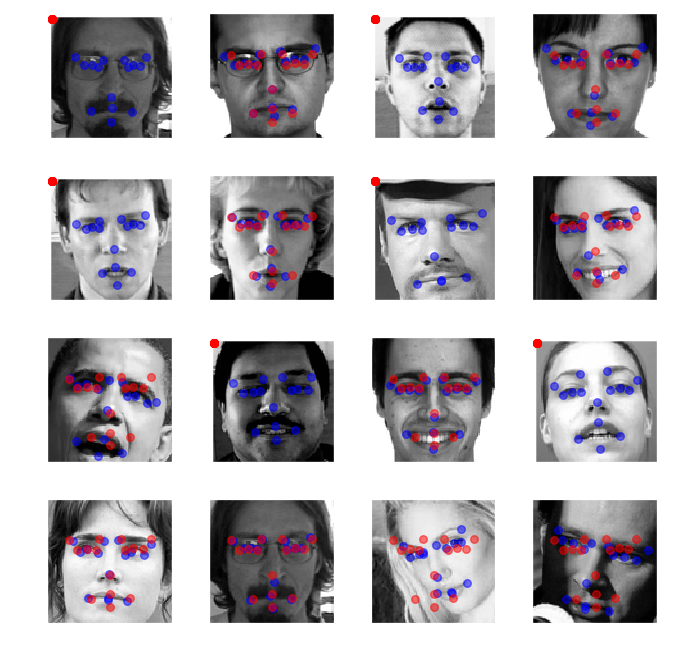

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Visualize
N_img_x = 4
N_img_y = 4
sel_idx = np.random.choice(X_train_clean_cv.shape[0], N_img_x * N_img_y, replace=False).reshape(N_img_x, N_img_y)
print sel_idx

plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
for n_y in range(N_img_y):
    for n_x in range(N_img_x):
        i = sel_idx[n_x][n_y]
        a = X_train_clean_cv[i].reshape(96, 96)
        b = y_train_clean_cv[i]
        b_x = b[0::2]
        b_y = b[1::2]
        
        o = out_train_clean_cv[i]
        o_x = o[0::2]
        o_y = o[1::2]
        

        plt.subplot(N_img_x, N_img_y, n_y * N_img_x + n_x + 1)
        plt.imshow(a)
        plt.scatter(b_x, b_y, s=30, alpha=0.5, color='blue')
        plt.scatter(o_x, o_y, s=30, alpha=0.5, color='red')
        plt.gca().axis('off')
plt.show()

[[169 186 419 369]
 [347  66 137 185]
 [ 43 466 236 176]
 [242 456 174  44]]


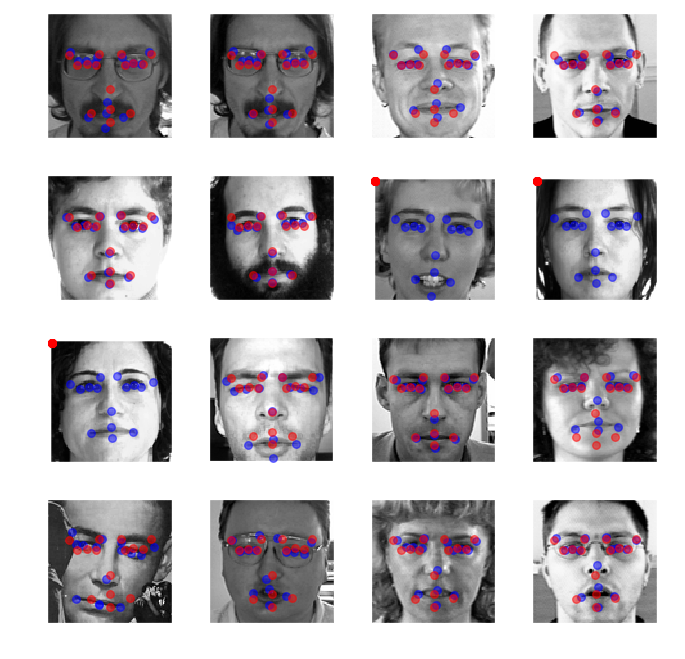

In [8]:
# Visualize
N_img_x = 4
N_img_y = 4
sel_idx = np.random.choice(X_val_clean_cv.shape[0], N_img_x * N_img_y, replace=False).reshape(N_img_x, N_img_y)
print sel_idx

plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
for n_y in range(N_img_y):
    for n_x in range(N_img_x):
        i = sel_idx[n_x][n_y]
        a = X_val_clean_cv[i].reshape(96, 96)
        b = y_val_clean_cv[i]
        b_x = b[0::2]
        b_y = b[1::2]
        
        o = out_val_clean_cv[i]
        o_x = o[0::2]
        o_y = o[1::2]
        

        plt.subplot(N_img_x, N_img_y, n_y * N_img_x + n_x + 1)
        plt.imshow(a)
        plt.scatter(b_x, b_y, s=30, alpha=0.5, color='blue')
        plt.scatter(o_x, o_y, s=30, alpha=0.5, color='red')
        plt.gca().axis('off')
plt.show()

In [9]:
import os.path
import pandas as pd

np_loaded_data_file = "../data/test_data.npz"
if not os.path.isfile(np_loaded_data_file):
    print "reading data ..."
    try:
        df=pd.read_csv('../data/test.csv', sep=',')
    except:
        print "Download test.csv from kaggle website"
    input_test = df.values
    
    X_test = input_test[:, 1]
    
    templist = []
    for i in range(X_test.shape[0]):
        templist.append([int(s) for s in X_test[i].split()])
    X_test = np.array(templist)
    
    X_test = X_test.astype(float)
    np.savez(np_loaded_data_file, X_test=X_test)
    print "saved %s ...." % np_loaded_data_file
else:
    print "training data %s exists. loading... " % np_loaded_data_file
    npzfile = np.load(np_loaded_data_file)
    X_train = npzfile['X_train']
    y_train = npzfile['y_train']

reading data ...


In [16]:
X_test = X_test - np.mean(X_test)
num_test_images = X_test.shape[0]

input_size = 96
X_test = X_test.reshape(-1, 1, input_size, input_size)

batch_size = 128
zero_pad = np.zeros(( batch_size - (num_test_images % batch_size), 1, input_size, input_size))

X_test = np.append(X_test, zero_pad, axis=0)


num_batches = X_test.shape[0] // batch_size
# num_batches = 1
out_test = np.zeros((X_test.shape[0], 30) )

for it in range(num_batches):
    it_range = range(it*batch_size,it*batch_size+batch_size)
    net.blobs['data'].data[...] = X_test[it_range]
    net.forward()
    out = net.blobs['score'].data
    out_test[it_range, :] = out
    
out_test = out_test[0:num_test_images]


In [33]:
feature_label_lookup_table = dict(zip(feature_labels[0:30], range(30)))
try:
    df=pd.read_csv('../data/IdLookupTable.csv', sep=',')
except:
    print "Download IdLookupTable.csv from kaggle website"
input_test = df.values

row_ids = input_test[:, 0]
image_ids = input_test[:, 1]
feature_names = input_test[:, 2]
locations = np.zeros(image_ids.shape[0])

for row_id, image_id, feature_name in zip(row_ids, image_ids, feature_names):
    locations[row_id-1] = out_test[image_id, feature_label_lookup_table[feature_name]]
    

df_save = pd.DataFrame(index=row_ids, data=locations, columns=['Location'], index_label='RowId')
df_save.to_csv('../data/submission_20161011.csv')

TypeError: __init__() got an unexpected keyword argument 'index_label'